In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, RocCurveDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import json
import joblib
from sklearn.inspection import permutation_importance

df = pd.read_csv('S06-hw-dataset-01.csv', sep=',', encoding='cp1251', skipinitialspace=True, decimal=',')
print(df.head())
print("++++++++++INFO++++++++++")
print(df.info())
print("++++++++++DESCRIBE++++++++++")
print(df.describe())
print("++++++++++TARGET DESTR++++++++++")
print(df['target'].value_counts(normalize=True))
print("++++++++++NULL++++++++++")
print(df.isna().mean())
print("++++++++++DUPLICATES++++++++++")
print(df[df.duplicated()])

   id                num01                num02                num03  \
0   1  -0.9460582099819794  -0.0703132762404737   1.8244454556295222   
1   2   -2.484027053625434    0.739378344022594   1.5969077741732804   
2   3   1.5226291123152595    7.159635337826522  -0.5649034953256873   
3   4   0.4633731713451892     -1.0739076651917   1.7528129741666811   
4   5    3.188389598607735   -4.701692299623068  -0.6899176782398833   

                  num04                 num05                 num06  \
0    -2.754422119334114    0.8088653522279924  -0.11109398456627925   
1   -2.5864791552562316  -0.03322454508791046   -3.0544117865883447   
2    -4.493109546752034    1.6236102000094015      5.45018667703096   
3   0.36278574849759626    2.7908719773288584    4.0823847683752765   
4  -0.44899517850122683    0.3738206889878842   -3.2753626987225157   

                 num07               num08                 num09  ...  \
0  -0.2689496760995246  -3.078209696124086    0.8012745384400579  .

=== Бейзлайн (DummyClassifier, most_frequent) ===
Accuracy : 0.6766666666666666
ROC-AUC  : 0.6766666666666666
F1-score : 0.0
=== Бейзлайн LogisticRegression ===
Accuracy на тесте:  0.8275
ROC-AUC на тесте:   0.8746778350515464
F1-score : 0.7080394922425952


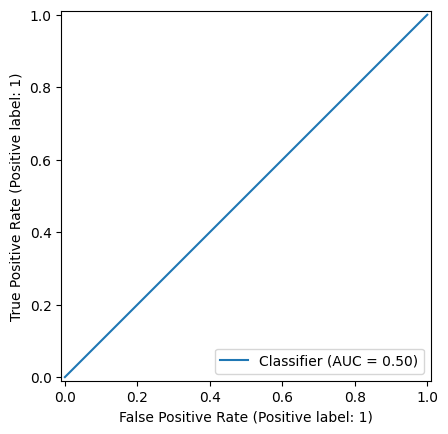

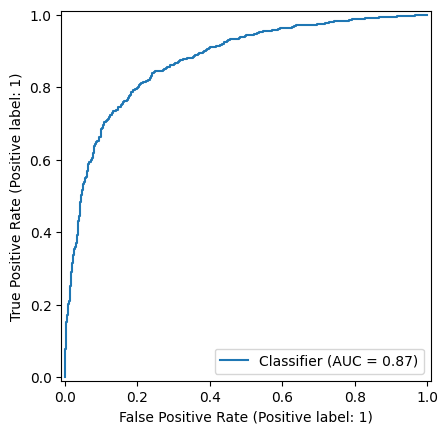

In [4]:
y = df['target']
X = df.drop(columns=['target', 'id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)
y_test_pred_baseline = baseline.predict(X_test)
y_test_proba_baseline = baseline.predict_proba(X_test)[:, 1]
dum_ac = accuracy_score(y_test, y_test_pred_baseline)
print("=== Бейзлайн (DummyClassifier, most_frequent) ===")
print("Accuracy :", dum_ac)
try:
    dum_roc = accuracy_score(y_test, y_test_pred_baseline)
    print("ROC-AUC  :", dum_roc)
except ValueError as e:
    print("Не удалось посчитать ROC-AUC:", e)
dum_f1 = f1_score(y_test, y_test_pred_baseline, zero_division=0)
print("F1-score :", dum_f1)
RocCurveDisplay.from_predictions(y_test, y_test_pred_baseline,)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
log_ac = accuracy_score(y_test, y_pred)
print("=== Бейзлайн LogisticRegression ===")
print("Accuracy на тесте: ", log_ac)
log_roc = roc_auc_score(y_test, y_proba)
print("ROC-AUC на тесте:  ", log_roc)
log_f1 = f1_score(y_test, y_pred, zero_division=0)
print("F1-score :", log_f1)
RocCurveDisplay.from_predictions(y_test, y_proba)

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 20}
Лучший CV ROC-AUC: 0.8950307371333579
=== DecisionTreeClassifier train ===
Accuracy на трейне:  0.8891666666666667
ROC-AUC на трейне:   0.9285274068123751
F1-score : 0.8157256667821268
confusion_matrix:
[[6181  314]
 [ 750 2355]]
=== DecisionTreeClassifier test ===
Accuracy на тесте:  0.8545833333333334
ROC-AUC на тесте:   0.8945588244629527
F1-score : 0.7571329157967989
confusion_matrix:
[[1507  117]
 [ 232  544]]


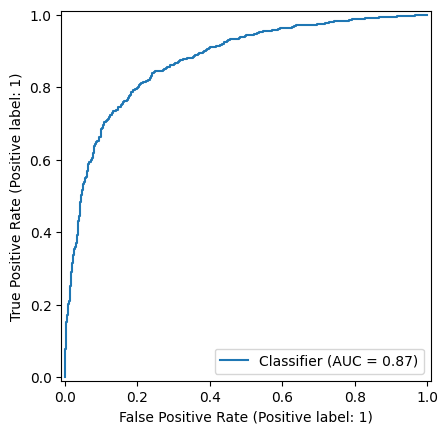

In [7]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20],
}
tree = DecisionTreeClassifier(random_state=42)
grid_dec = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_dec.fit(X_train, y_train)
print("Лучшие параметры:", grid_dec.best_params_)
print("Лучший CV ROC-AUC:", grid_dec.best_score_)
best_tree = grid_dec.best_estimator_
y_pred_train = best_tree.predict(X_train)
y_pred_test = best_tree.predict(X_test)
y_proba_train = best_tree.predict_proba(X_train)[:, 1]  # для бинарной классификации
y_proba_test = best_tree.predict_proba(X_test)[:, 1]
print("=== DecisionTreeClassifier train ===")
dec_ac_tr = accuracy_score(y_train, y_pred_train)
print("Accuracy на трейне: ", dec_ac_tr)
dec_roc_tr = roc_auc_score(y_train, y_proba_train)
print("ROC-AUC на трейне:  ", dec_roc_tr)
dec_f1_tr = f1_score(y_train, y_pred_train, zero_division=0)
print("F1-score :", dec_f1_tr)
print("confusion_matrix:")
print(confusion_matrix(y_train, y_pred_train))
print("=== DecisionTreeClassifier test ===")
dec_ac_ts = accuracy_score(y_test, y_pred_test)
print("Accuracy на тесте: ", dec_ac_ts)
dec_roc_ts = roc_auc_score(y_test, y_proba_test)
print("ROC-AUC на тесте:  ", dec_roc_ts)
dec_f1_ts = f1_score(y_test, y_pred_test, zero_division=0)
print("F1-score :", dec_f1_ts)
print("confusion_matrix:")
print(confusion_matrix(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.savefig('artifacts/figures/rocDec.png', bbox_inches='tight')

=== RandomForestClassifier train ===
Accuracy на трейне:  0.9515625
ROC-AUC на трейне:   0.9917421427854203
F1-score:  0.9201716738197425
confusion_matrix:
[[6455   40]
 [ 425 2680]]
=== RandomForestClassifier test ===
Accuracy на тесте:  0.9083333333333333
ROC-AUC на тесте:   0.9590493436087553
F1-score:  0.8457223001402524
confusion_matrix:
[[1577   47]
 [ 173  603]]


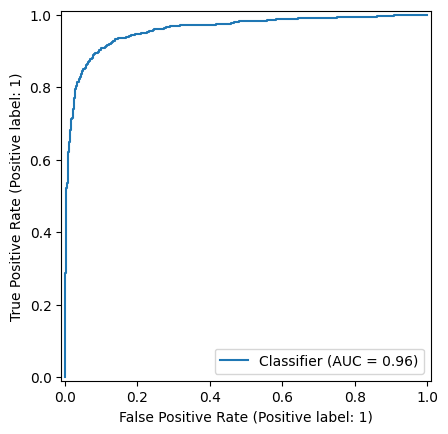

In [8]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)
y_proba_train = best_rf.predict_proba(X_train)[:, 1]
y_proba_test = best_rf.predict_proba(X_test)[:, 1]
rf_ac_tr = accuracy_score(y_train, y_pred_train)
rf_roc_tr = roc_auc_score(y_train, y_proba_train)
rf_f1_tr = f1_score(y_train, y_pred_train, zero_division=0)
print("=== RandomForestClassifier train ===")
print("Accuracy на трейне: ", rf_ac_tr)
print("ROC-AUC на трейне:  ", rf_roc_tr)
print("F1-score: ", rf_f1_tr)
print("confusion_matrix:")
print(confusion_matrix(y_train, y_pred_train))
rf_ac_ts = accuracy_score(y_test, y_pred_test)
rf_roc_ts = roc_auc_score(y_test, y_proba_test)
rf_f1_ts = f1_score(y_test, y_pred_test, zero_division=0)
print("=== RandomForestClassifier test ===")
print("Accuracy на тесте: ", rf_ac_ts)
print("ROC-AUC на тесте:  ", rf_roc_ts)
print("F1-score: ", rf_f1_ts)
print("confusion_matrix:")
print(confusion_matrix(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_proba_test)
plt.savefig('artifacts/figures/roc.png', bbox_inches='tight')

=== AdaBoostClassifier train ===
Accuracy на трейне:  0.8510416666666667
ROC-AUC на трейне:   0.9177509021556283
F1-score:  0.7476173667490293
confusion_matrix:
[[6052  443]
 [ 987 2118]]

=== AdaBoostClassifier test ===
Accuracy на тесте:  0.83625
ROC-AUC на тесте:   0.899413516962064
F1-score:  0.7234342012667135
confusion_matrix:
[[1493  131]
 [ 262  514]]


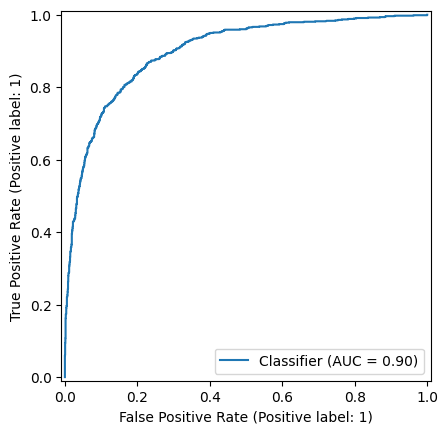

In [5]:
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
param_grid = {
    'n_estimators': [20, 35, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)
grid_ada = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_ada.fit(X_train, y_train)
best_ada = grid_ada.best_estimator_
y_pred_train = best_ada.predict(X_train)
y_pred_test = best_ada.predict(X_test)
y_proba_train = best_ada.predict_proba(X_train)[:, 1]
y_proba_test = best_ada.predict_proba(X_test)[:, 1]
ada_ac_tr = accuracy_score(y_train, y_pred_train)
ada_roc_tr = roc_auc_score(y_train, y_proba_train)
ada_f1_tr = f1_score(y_train, y_pred_train, zero_division=0)
print("=== AdaBoostClassifier train ===")
print("Accuracy на трейне: ", ada_ac_tr)
print("ROC-AUC на трейне:  ", ada_roc_tr)
print("F1-score: ", ada_f1_tr)
print("confusion_matrix:")
print(confusion_matrix(y_train, y_pred_train))
ada_ac_ts = accuracy_score(y_test, y_pred_test)
ada_roc_ts = roc_auc_score(y_test, y_proba_test)
ada_f1_ts = f1_score(y_test, y_pred_test, zero_division=0)
print("\n=== AdaBoostClassifier test ===")
print("Accuracy на тесте: ", ada_ac_ts)
print("ROC-AUC на тесте:  ", ada_roc_ts)
print("F1-score: ", ada_f1_ts)
print("confusion_matrix:")
print(confusion_matrix(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_proba_test)

=== GradientBoostingClassifier train ===
Accuracy на трейне:  0.968125
ROC-AUC на трейне:   0.9941254947754931
F1-score:  0.9494715984147952
confusion_matrix:
[[6419   76]
 [ 230 2875]]

=== GradientBoostingClassifier test ===
Accuracy на тесте:  0.9225
ROC-AUC на тесте:   0.9675422781981617
F1-score:  0.8748317631224765
confusion_matrix:
[[1564   60]
 [ 126  650]]


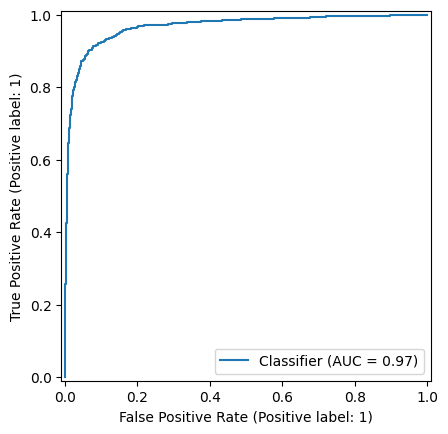

In [9]:
param_grid = {
    'n_estimators': [30, 50, 70, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_leaf': [5, 10]
}
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_
y_pred_train = best_gb.predict(X_train)
y_pred_test = best_gb.predict(X_test)
y_proba_train = best_gb.predict_proba(X_train)[:, 1]
y_proba_test = best_gb.predict_proba(X_test)[:, 1]
gb_ac_tr = accuracy_score(y_train, y_pred_train)
gd_roc_tr = roc_auc_score(y_train, y_proba_train)
gr_f1_tr = f1_score(y_train, y_pred_train, zero_division=0)
print("=== GradientBoostingClassifier train ===")
print("Accuracy на трейне: ", gb_ac_tr)
print("ROC-AUC на трейне:  ", gd_roc_tr)
print("F1-score: ", gr_f1_tr)
print("confusion_matrix:")
print(confusion_matrix(y_train, y_pred_train))
gb_ac_ts = accuracy_score(y_test, y_pred_test)
gb_roc_ts = roc_auc_score(y_test, y_proba_test)
gb_f1_ts = f1_score(y_test, y_pred_test, zero_division=0)
print("\n=== GradientBoostingClassifier test ===")
print("Accuracy на тесте: ", gb_ac_ts)
print("ROC-AUC на тесте:  ", gb_roc_ts)
print("F1-score: ", gb_f1_ts)
print("confusion_matrix:")
print(confusion_matrix(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_proba_test)

In [10]:
best_model = best_gb
perm_imp = permutation_importance(
    best_model,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values('importance', ascending=False)
top_n = 15
print(f"\n=== Top-{top_n} признаков по Permutation Importance ===")
print(perm_df.head(top_n)[['feature', 'importance']])


=== Top-15 признаков по Permutation Importance ===
   feature  importance
17   num18    0.076092
18   num19    0.070299
6    num07    0.039682
3    num04    0.017626
23   num24    0.016316
19   num20    0.011471
21   num22    0.009448
0    num01    0.009332
13   num14    0.007057
15   num16    0.005932
16   num17    0.005569
20   num21    0.004404
7    num08    0.003049
1    num02    0.002577
12   num13    0.002027


In [14]:
summary_df = pd.DataFrame({
    "Модель": ["DummyClassifier (бейзлайн)", "LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "AdaBoostClassifier", "GradientBoostingClassifier"],
    "Accuracy": [dum_ac, log_ac, dec_ac_ts, rf_ac_ts, ada_ac_ts, gb_ac_ts],
    "ROC-AUC": [dum_roc, log_roc, dec_roc_ts, rf_roc_ts, ada_roc_ts, gb_roc_ts],
    "F1": [dum_f1, log_f1, dec_f1_ts, rf_f1_ts, ada_f1_ts, gb_f1_ts]
})
print(summary_df)
summary_df.to_csv("artifacts/metrics_test.csv", index=False)
search_summaries = {
    "DecisionTreeClassifier": {
        "best_params": grid_dec.best_params_,
        "best_cv_score": float(grid_dec.best_score_)
    },
    "RandomForestClassifier": {
        "best_params": grid_rf.best_params_,
        "best_cv_score": float(grid_rf.best_score_)
    },
    "AdaBoostClassifier": {
        "best_params": grid_ada.best_params_,
        "best_cv_score": float(grid_ada.best_score_)
    },
    "GradientBoostingClassifier": {
        "best_params": grid_search.best_params_,
        "best_cv_score": float(grid_search.best_score_)
    }
}
with open("artifacts/search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=4, ensure_ascii=False)
joblib.dump(best_gb, "artifacts/best_model.joblib")
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)[:, 1]
meta = {
    "best_model_name": "GradientBoostingClassifier",
    "best_params": search_summaries["GradientBoostingClassifier"]["best_params"],
    "test_metrics": {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_proba)),
        "f1_score": float(f1_score(y_test, y_pred, zero_division=0))
    }
}
with open("artifacts/best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=4, ensure_ascii=False)

                       Модель  Accuracy   ROC-AUC        F1
0  DummyClassifier (бейзлайн)  0.676667  0.676667  0.000000
1          LogisticRegression  0.827500  0.874678  0.708039
2      DecisionTreeClassifier  0.854583  0.894559  0.757133
3      RandomForestClassifier  0.908333  0.959049  0.845722
4          AdaBoostClassifier  0.836250  0.899414  0.723434
5  GradientBoostingClassifier  0.922500  0.967542  0.874832


Наибольшее влияние на предсказания модели оказывают признаки num18 и num19: их перестановка снижает ROC-AUC на ~0.07–0.08, 
что указывает на высокую предсказательную силу. Следующий по важности — num07 (вклад ~0.04), тогда как остальные признаки вносят 
значительно меньший вклад (менее 0.02).
Такое распределение говорит о том, что лишь небольшая часть признаков (2–3 из 24) действительно информативна, а остальные почти не
влияют на решение модели. 